
## 1. Create Neural Network from Scratch 

<h3 style='color:Blue'>
Input Description
</h3>

*Input* :
The input consists of $m$ training images of shape 28x28 pixels. Consequently, each image is represented by a 1-dimensional array of size 784. In order to speed up the computations, I will take advantage of the vectorization technique. I will store the entire training set in a single matrix $X$. Each column of $X$ represents a training example:

$ X = 
 \begin{bmatrix}
\vdots & \vdots & \vdots & \vdots\\
x^{(1)} & x^{(2)} &  ... & x^{(m)}\\
\vdots & \vdots & \vdots & \vdots \\
\end{bmatrix}
$



In [20]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

The dimensions are : $X \in \mathbb{R}^{784xm} $

In [21]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [22]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

<h3 style='color:Blue'>
Neural Network
</h3>

To have the big step of deep learning : 
* We feed input data into the neural network.
* The data flows from layer to layer until we have the output.
* Once we have the output, we can calculate the error which is a scalar.
* Finally we can adjust a given parameter (weight or bias) by subtracting the derivative of the error with respect to the parameter itself.

We iterate through that process.

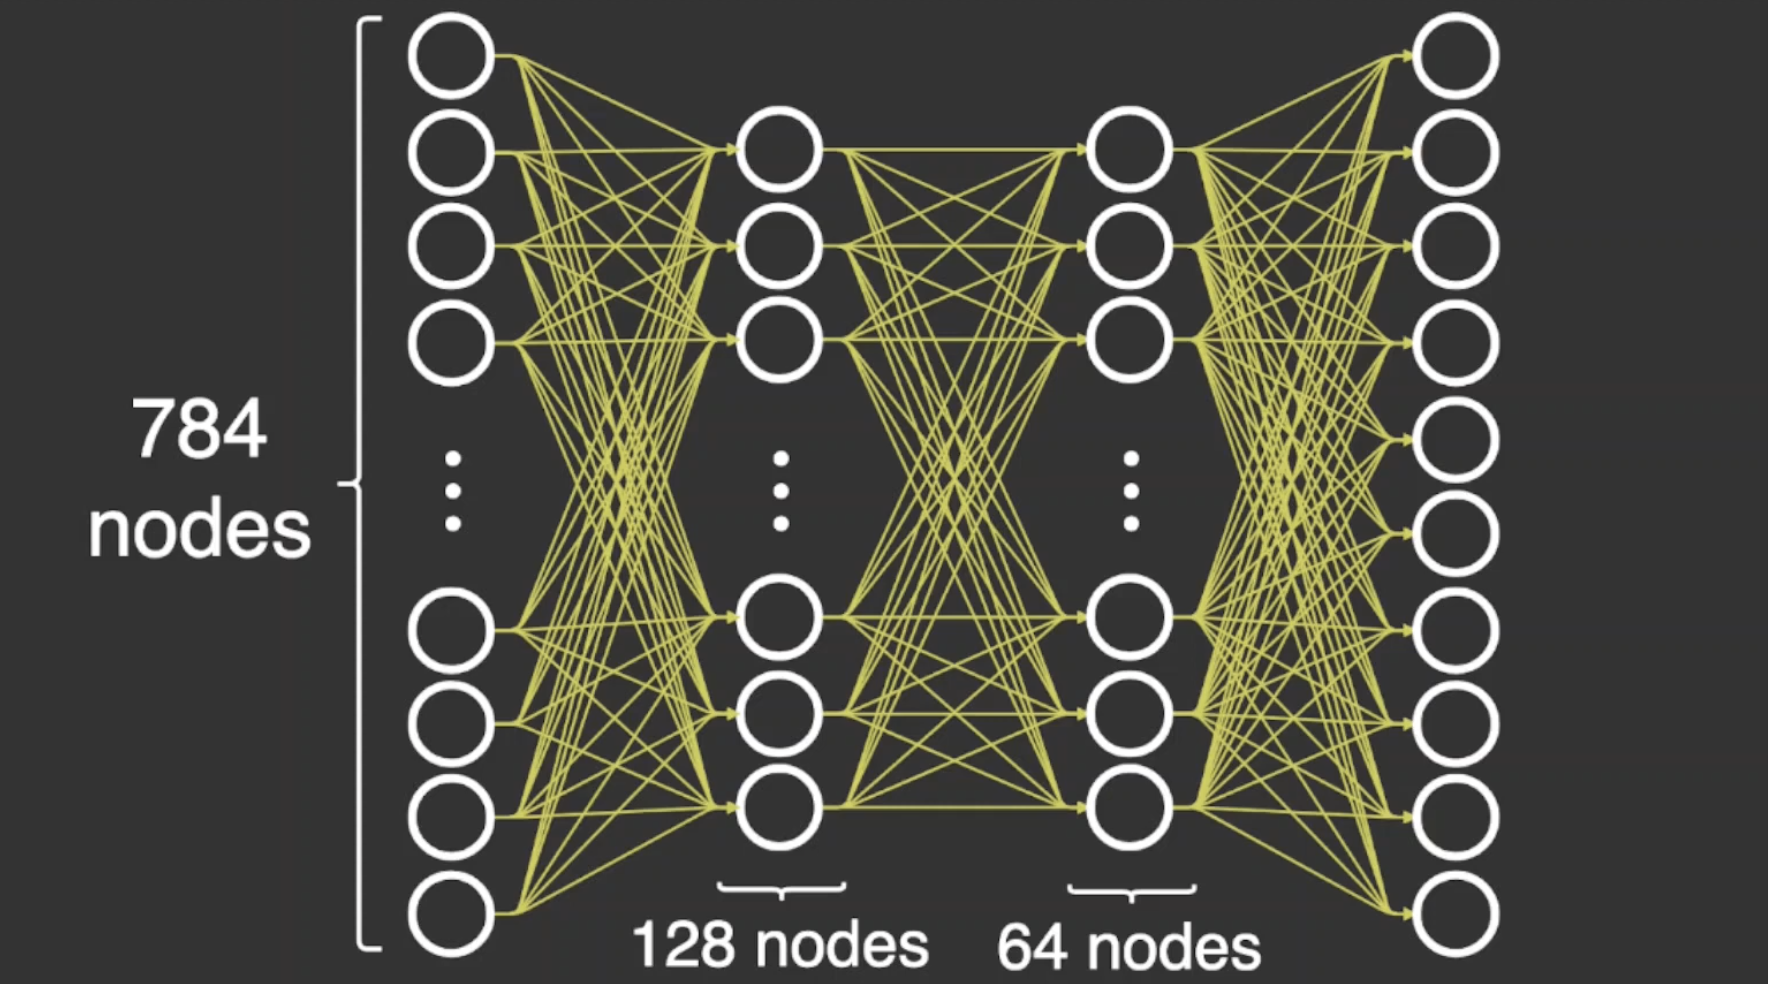

To clarify the explanation, let’s assume building a neural network composed of:

* input layer (784 nodes)
* 1 hidden layer of size 10 with ReLu activation function (128 nodes)
* 1 hidden layer of size 10 with Softmax activation function (64 nodes)
* output layer (10 nodes)

<h4 style="color:green;">
    A. Forward Propagation
</h4>

The forward propagation, for each layer, is composed of 2 steps:

* application of weights and biases
* computation of the activation function

This is called forward propagation. Essentially, we give the input data to the first layer, then the output of every layer becomes the input of the next layer until we reach the end of the network. By comparing the result of the network (Y) with the desired output (let’s say Y*), we can calculate en error E. The goal is to minimize that error by changing the parameters in the network. That is backward propagation (backpropagation).

$$
\Large b_j + \sum_{i}x_iw_{ij}
$$

<h4 style="color:green;">
    B. Backward Propagation
</h4>

Suppose that we give a layer the derivative of the error with respect to its output $\frac{∂E}{∂X}$, then it must be able to provide the derivative of the error with respect to its input $\frac{∂E}{∂X}$.

*Remember that $E$ is a scalar (a number) and $X$ and $Y$ are matrices.*

As we said, suppose we have a matrix containing the derivative of the error with respect to that layer’s output ($\frac{∂E}{∂Y}$). We need :

1. The derivative of the error with respect to the parameters ($\frac{∂E}{∂W}$, $\frac{∂E}{∂B}$)
2. The derivative of the error with respect to the input ($\frac{∂E}{∂X}$)


In [23]:
##### Utils functions 
def sigmoid(s):
    return 1 / (1 + torch.exp(-s))

def sigmoidPrime(s):
    # derivative of sigmoid
    # s: sigmoid output
    return s * (1 - s)


In [64]:
class Neural_Network:
    def __init__(self, input_size=784, output_size=10, hidden_size=32):
        # parameters
        self.inputSize = input_size
        self.outputSize = output_size
        self.hiddenSize = hidden_size
        self.loss = 0
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize)  # self.W1 * X_train [10,000, 784]
        self.b1 = torch.zeros(self.hiddenSize) 
        
        self.W2 = torch.randn(self.hiddenSize, self.outputSize)
        self.b2 = torch.zeros(self.outputSize)
        
    def forward(self, X):
        
        self.z1 = torch.matmul(X, self.W1) + self.b1
        self.h = sigmoid(self.z1) 
        self.z2 = torch.matmul(self.h, self.W2) + self.b2
        return sigmoid(self.z2)
            
    def backward(self, X, y, y_hat, lr=.1):
        # y holds the label with numbers form 0-9 [100]
        # t is the 1-hot version of y  [100,10]
        # y_hat looks like t
        
        t = torch.zeros(y_hat.size()).type(y.type())
        for n in range(t.size(0)):
            t[n][y[n]] = 1
#         print(t.shape, y_hat.shape)

        batch_size = y.size(0)
        loss_batch = torch.sum((y_hat - t)**2) / batch_size
        
        self.loss = (loss_batch)
        
        dl_dz2 = (1/batch_size)*(y_hat - t)
        dl_dh = torch.matmul(dl_dz2, torch.t(self.W2))
        dl_dz1 = dl_dh * sigmoidPrime(self.h)
        
        self.W1 -= lr*torch.matmul(torch.t(X), dl_dz1)
        self.b1 -= lr*torch.matmul(torch.t(dl_dz1), torch.ones(batch_size))
        self.W2 -= lr*torch.matmul(torch.t(self.h), dl_dz2)
        self.b2 -= lr*torch.matmul(torch.t(dl_dz2), torch.ones(batch_size))
    
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        o.shape, y.shape
        self.backward(X, y, o)
    
    def getLoss(self):
        return self.loss 
    
    def getWeight(self):
        return self.W1,self.b1,self.W2,self.b2
    
    def saveModel(self):
    # Save the Model
        torch.save({'W1': self.W1,
                    'b1': self.b1,
                    'W2': self.W2,
                    'b2': self.b2}, 'model.pkl')

    def loadModel(self, path):
        myModel = torch.load(path)
        self.W1 = myModel["W1"]
        self.b1 = myModel["b1"]
        self.W2 = myModel["W2"]
        self.b2 = myModel["b2"]
    
    def printWeight(self):
        print(f"W1  = {self.W1}")
        print(f"b1  = {self.b1}")
        print(f"W2  = {self.W2}")
        print(f"b2  = {self.b2}")

  
        

In [65]:
model = Neural_Network()

In [66]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        model.train(images,labels)
        

        if (i+1) % 300 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, model.getLoss()))
# model.printWeight()

Epoch [1/5], Step [300/600], Loss: 0.6604
Epoch [1/5], Step [600/600], Loss: 0.5784
Epoch [2/5], Step [300/600], Loss: 0.4429
Epoch [2/5], Step [600/600], Loss: 0.4357
Epoch [3/5], Step [300/600], Loss: 0.3946
Epoch [3/5], Step [600/600], Loss: 0.3169
Epoch [4/5], Step [300/600], Loss: 0.3903
Epoch [4/5], Step [600/600], Loss: 0.2788
Epoch [5/5], Step [300/600], Loss: 0.2181
Epoch [5/5], Step [600/600], Loss: 0.3478


In [67]:
W1,b1,W2,b2 = model.getWeight()
# Save the Model
torch.save({'W1': W1,
            'b1': b1,
            'W2': W2,
            'b2': b2}, 'model.pkl')

In [69]:
# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')

Accuracy of the network on the 10000 test images: 83.3 %
